## Environment setup

In [1]:
!apt install libgraphviz-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 23 not upgraded.
Need to get 2,148 kB of archives.
After this operation, 7,427 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-common all 2.24.32-4ubuntu4 [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-0 amd64 2.24.32-4ubuntu4 [1,791 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail18 amd64 2.24.32-4ubuntu4 [14.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail-common amd64 2.24.32-4ub

In [2]:
!pip install pyLDAvis
!pip install pygraphviz
!pip install bertopic
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 4.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.6/120.6 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.10-cp39-cp39-linux_x86_64.whl size=183755 s

In [4]:
import re
import pandas as pd
import numpy as np
import sqlite3
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly
import bertopic

sns.set(style="darkgrid")
pd.set_option('display.max_colwidth', 80)

Mounted at /drive


## Loading the data

In [5]:
con = sqlite3.connect('db.sqlite')

In [6]:
df = pd.read_sql_query('SELECT * from articles WHERE gsrank <= 500', con)
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.replace('NA', np.nan)
n = len(df)
print(f'Loaded {n} articles.')

tkeywords = 'learn|deep|machine|classification|regression|artificial intelligence'
cs_articles = df.title.str.contains(tkeywords, case=False) | df.abstract.str.contains(tkeywords, case=False)
nr = len(df[~cs_articles])
df.drop(df.index[~cs_articles], inplace=True)
n = len(df)
print(f'Removed {nr} articles not related to CS. Total articles: {n}')

keywords = 'emergency department'
ed_articles = df.title.str.contains(keywords, case=False) | df.abstract.str.contains(keywords, case=False)
nr = len(df[~ed_articles])
df.drop(df.index[~ed_articles], inplace=True)
n = len(df)
print(f'Removed {nr} articles not related to ED. Total articles: {n}')

pub_articles = (df.pub_type == 'article') | (df.pub_type == 'inproceedings')
nr = len(df[~pub_articles])
df.drop(df.index[~pub_articles], inplace=True)
n = len(df)
print(f'Removed {nr} articles not article ot inproceedings. Total articles: {n}')

filtered_df = pd.read_csv('articles.csv')
filtered_articles = df[df.id.isin(filtered_df[filtered_df['filtered'] == 1]['id'])]
nr = len(filtered_articles)
df.drop(filtered_articles.index, inplace=True)
n = len(df)
print(f'Removed {nr} articles by manual screening. Total articles: {n}')

Loaded 1406 articles.
Removed 696 articles not related to CS. Total articles: 710
Removed 33 articles not related to ED. Total articles: 677
Removed 12 articles not article ot inproceedings. Total articles: 665
Removed 242 articles by manual screening. Total articles: 423


In [7]:
df['pub_year'] = df['pub_year'].astype(int)

In [8]:
df.head()

id    scholar_id  \
0   1  OoEvRGBnr-QJ   
1   2  8gNE1qbzqkgJ   
2   3  cUgwhGZ9NZcJ   
3   4  ExU4btq0S00J   
4   5  j5_RnYS065EJ   

                                                                             title  \
0  Applications of machine learning to undifferentiated chest pain in the emerg...   
1  Predicting urinary tract infections in the emergency department with machine...   
2  Emergency department triage prediction of clinical outcomes using machine le...   
3  Predicting hospital admission at emergency department triage using machine l...   
4  Machine learning--based prediction of clinical outcomes for children during ...   

                                                                          abstract  \
0  presenting to an emergency department with undifferentiated  development of ...   
1  In this study developing and validating models for prediction of urinary tra...   
2  Development of emergency department (ED) triage systems that accurately diff...   
3  Our study shows that machine learning can robustly predict hospital admissio...   
4  Question Do machine learning approaches improve the  and disposition of chil...   

                    bib_id            journal number             pages  \
0  stewart2021applications           PloS one      8          e0252612   
1     taylor2018predicting           PloS one      3          e0194085   
2       raita2019emergency      Critical care      1             1--13   
3       hong2018predicting           PloS one      7          e0201016   
4          goto2019machine  JAMA network open      1  e186937--e186937   

  pub_type  pub_year  ... gsrank  \
0  article      2021  ...      1   
1  article      2018  ...      2   
2  article      2019  ...      3   
3  article      2018  ...      4   
4  article      2019  ...      5   

                                                         citedby_url  \
0  /scholar?cites=16478503224730419514&as_sdt=5,33&sciodt=1,33&hl=en   
1   /scholar?cites=5236265414656525298&as_sdt=5,33&sciodt=1,33&hl=en   
2  /scholar?cites=10895752752750676081&as_sdt=5,33&sciodt=1,33&hl=en   
3   /scholar?cites=5569744214418789651&as_sdt=5,33&sciodt=1,33&hl=en   
4  /scholar?cites=10514696236702998415&as_sdt=5,33&sciodt=1,33&hl=en   

                                                                  eprint_url  \
0  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
1  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0194085   
2       https://ccforum.biomedcentral.com/articles/10.1186/s13054-019-2351-7   
3  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0201016   
4       https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2720586   

                                                                     pub_url  \
0  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
1  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0194085   
2       https://ccforum.biomedcentral.com/articles/10.1186/s13054-019-2351-7   
3  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0201016   
4  https://jamanetwork.com/journals/jamanetworkopen/article-abstract/2720586   

                                                                     url_add_sclib  \
0  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   
1  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   
2  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   
3  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   
4  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   

                                                              url_related_articles  \
0  /scholar?q=related:OoEvRGBnr-QJ:scholar.google.com/&scioq=%22emergency+depar...   
1  /scholar?q=related:8gNE1qbzqkgJ:scholar.google.com/&scioq=%22emergency+depar...  

In [9]:
df.isna().sum()

id                        0
scholar_id                0
title                     0
abstract                  0
bib_id                    0
journal                  39
number                  130
pages                    42
pub_type                  0
pub_year                  0
publisher                57
venue                     8
volume                   52
num_citations             0
gsrank                    0
citedby_url              39
eprint_url              101
pub_url                   0
url_add_sclib             0
url_related_articles     32
url_scholarbib            0
search_term               0
depth                     0
fetched_citations         0
dtype: int64

In [10]:
df.describe()

id     pub_year        volume  num_citations      gsrank  \
count   423.000000   423.000000    371.000000     423.000000  423.000000   
mean    462.763593  2018.659574    142.487871      38.132388  167.271868   
std     440.713753     2.740334    648.010629      46.970763  117.266292   
min       1.000000  2012.000000      1.000000       0.000000    1.000000   
25%     112.500000  2017.000000     11.500000       6.000000   71.500000   
50%     269.000000  2020.000000     26.000000      20.000000  148.000000   
75%     763.500000  2021.000000     71.500000      55.000000  244.500000   
max    1956.000000  2022.000000  10575.000000     352.000000  495.000000   

       depth  fetched_citations  
count  423.0              423.0  
mean     0.0                0.0  
std      0.0                0.0  
min      0.0                0.0  
25%      0.0                0.0  
50%      0.0                0.0  
75%      0.0                0.0  
max      0.0                0.0

In [11]:
adf = pd.read_sql_query('SELECT * from authors', con)
adf = adf.replace(r'^\s*$', np.nan, regex=True)
adf = adf.replace('NA', np.nan)
adf = adf.fillna(np.nan)
adf.head()


id    scholar_id                 name            fullname  \
0   1  JOKd1xwAAAAJ    Stewart, Jonathon    Jonathon Stewart   
1   2           NaN             Lu, Juan                 NaN   
2   3           NaN       Goudie, Adrian                 NaN   
3   4  ylX5MEAAAAAJ  Bennamoun, Mohammed  Mohammed Bennamoun   
4   5           NaN     Sprivulis, Peter                 NaN   

                           affiliation  \
0      University of Western Australia   
1                                  NaN   
2                                  NaN   
3  The University of Western Australia   
4                                  NaN   

                                                                       url_picture  \
0  https://scholar.googleusercontent.com/citations?view_op=view_photo&user=JOKd...   
1                                                                              NaN   
2                                                                              NaN   
3  https://scholar.googleusercontent.com/citations?view_op=view_photo&user=ylX5...   
4                                                                              NaN   

                                                                         interests  \
0                         Anaesthesia, Emergency Medicine, Artificial Intelligence   
1                                                                              NaN   
2                                                                              NaN   
3  Object Recognition, Face Recognition, Biometrics, Computer Vision, Deep Lear...   
4                                                                              NaN   

   hindex  hindex5y  i10index  i10index5y  citedby  citedby5y  \
0     3.0       3.0       2.0         2.0    118.0      117.0   
1     NaN       NaN       NaN         NaN      NaN        NaN   
2     NaN       NaN       NaN         NaN      NaN        NaN   
3    68.0      53.0     284.0       197.0  21078.0    13850.0   
4     NaN       NaN       NaN         NaN      NaN        NaN   

           email_domain  \
0  @research.uwa.edu.au   
1                   NaN   
2                   NaN   
3           @uwa.edu.au   
4                   NaN   

                                                                         coauthors  
0                                                                               []  
1                                                                              NaN  
2                                                                              NaN  
3  [{'container_type': 'Author', 'filled': [], 'scholar_id': 'ijcKzIQAAAAJ', 's...  
4                                                                              NaN

In [12]:
cdf = pd.read_sql_query('SELECT * from article_author', con)
cdf.head()

article_id  author_id
0           1          1
1           1          2
2           1          3
3           1          4
4           1          5

In [13]:
mdf = cdf.merge(adf, left_on='author_id', right_on='id', suffixes=('_article', ''))\
         .merge(df, left_on='article_id', right_on='id', suffixes=('_author', ''))\
         .drop(columns=['id_author', 'id'])\
         .rename(columns={'scholar_id_author':'author_scholar_id'})

mdf.head()

article_id  author_id author_scholar_id                 name  \
0           1          1      JOKd1xwAAAAJ    Stewart, Jonathon   
1           1          2               NaN             Lu, Juan   
2           1          3               NaN       Goudie, Adrian   
3           1          4      ylX5MEAAAAAJ  Bennamoun, Mohammed   
4           1          5               NaN     Sprivulis, Peter   

             fullname                          affiliation  \
0    Jonathon Stewart      University of Western Australia   
1                 NaN                                  NaN   
2                 NaN                                  NaN   
3  Mohammed Bennamoun  The University of Western Australia   
4                 NaN                                  NaN   

                                                                       url_picture  \
0  https://scholar.googleusercontent.com/citations?view_op=view_photo&user=JOKd...   
1                                                                              NaN   
2                                                                              NaN   
3  https://scholar.googleusercontent.com/citations?view_op=view_photo&user=ylX5...   
4                                                                              NaN   

                                                                         interests  \
0                         Anaesthesia, Emergency Medicine, Artificial Intelligence   
1                                                                              NaN   
2                                                                              NaN   
3  Object Recognition, Face Recognition, Biometrics, Computer Vision, Deep Lear...   
4                                                                              NaN   

   hindex  hindex5y  ...  gsrank  \
0     3.0       3.0  ...       1   
1     NaN       NaN  ...       1   
2     NaN       NaN  ...       1   
3    68.0      53.0  ...       1   
4     NaN       NaN  ...       1   

                                                         citedby_url  \
0  /scholar?cites=16478503224730419514&as_sdt=5,33&sciodt=1,33&hl=en   
1  /scholar?cites=16478503224730419514&as_sdt=5,33&sciodt=1,33&hl=en   
2  /scholar?cites=16478503224730419514&as_sdt=5,33&sciodt=1,33&hl=en   
3  /scholar?cites=16478503224730419514&as_sdt=5,33&sciodt=1,33&hl=en   
4  /scholar?cites=16478503224730419514&as_sdt=5,33&sciodt=1,33&hl=en   

                                                                  eprint_url  \
0  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
1  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
2  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
3  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
4  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   

                                                                     pub_url  \
0  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
1  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
2  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
3  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   
4  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252612   

                                                                     url_add_sclib  \
0  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   
1  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   
2  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   
3  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   
4  /citations?hl=en&xsrf=&continue=/scholar%3Fq%3D%2522emergency%2Bdepartment%2...   

                                                              ur

## Performance Analysis

### Total publications (TP)

In [14]:
tp = df['id'].count()
tp

423

pub_year
2012    13
2013    17
2014    21
2015    21
2016    22
2017    17
2018    39
2019    61
2020    95
2021    69
2022    48
Name: id, dtype: int64

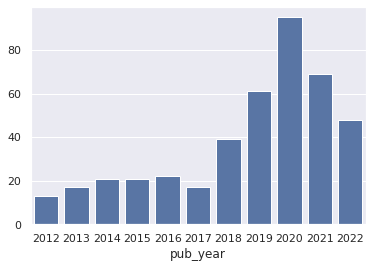

In [15]:
p = df.groupby('pub_year').count()['id']
pb = sns.barplot(x=p.index, y=p.values, color='b')
p

### Number of cited publications (NCP)

In [16]:
cited_df = df[df['num_citations'] > 0]
ncp = cited_df['id'].count()
ncp

384

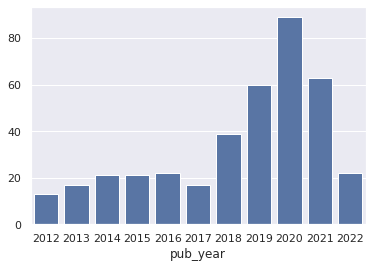

In [17]:
pc = cited_df.groupby('pub_year').count()['id']
pcb = sns.barplot(x=pc.index, y=pc.values, color='b')


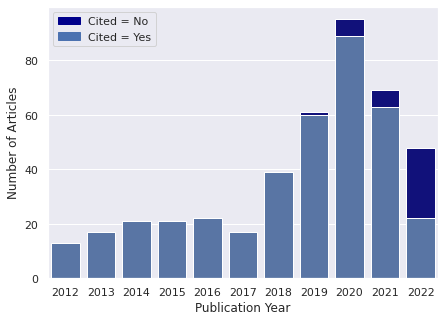

In [18]:
plt.figure(figsize=(7, 5))

pb = sns.barplot(x=p.index, y=p.values, color='darkblue')
pcb = sns.barplot(x=pc.index, y=pc.values, color='b')

top_bar = mpatches.Patch(color='darkblue', label='Cited = No')
bottom_bar = mpatches.Patch(color='b', label='Cited = Yes')
plt.legend(handles=[top_bar, bottom_bar])
plt.xlabel('Publication Year')
plt.ylabel('Number of Articles')
plt.savefig('publications.pdf')

### Number of contributing authors (NCA)

In [19]:
nca = len(mdf['author_id'].unique())
nca

1342

<Axes: xlabel='pub_year'>

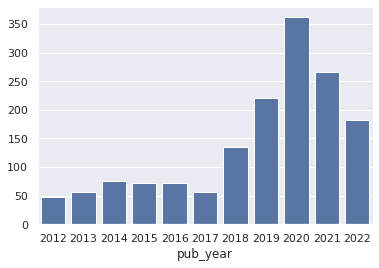

In [20]:
a = mdf.groupby('pub_year').count()['author_id']
sns.barplot(x=a.index, y=a.values, color='b')

### Collaboration coefficient (CC) = 1 – (TP ÷ NCA)

In [21]:
cc = 1-(tp/nca)
cc

0.6847988077496274

In [22]:
ccp = (1-(df.groupby('pub_year').count()['id']/mdf.groupby('pub_year').count()['author_id']))

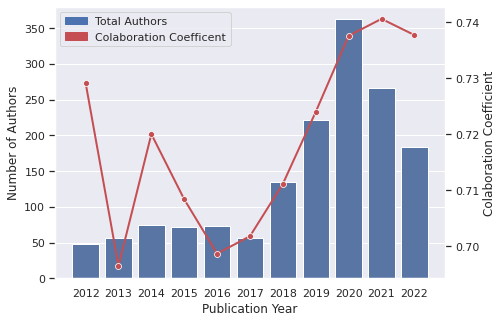

In [23]:
fig, ax1 = plt.subplots(figsize=(7,5))

sns.barplot(x=a.index, y=a.values, ax=ax1, color='b', label='d')
ax2 = ax1.twinx()
# ax1.grid(False)
ax2.grid(False)

sns.lineplot(x=ax1.get_xticks(), y=ccp.values, ax=ax2, color='r', label='a', linewidth=2, marker='o')

bar = mpatches.Patch(color='b', label='Total Authors')
line = mpatches.Patch(color='r', label='Colaboration Coefficent', )
plt.legend(handles=[bar, line])

ax1.set_xlabel('Publication Year')
ax2.set_ylabel('Colaboration Coefficient')
ax1.set_ylabel('Number of Authors')
plt.savefig('authors.pdf')

### Total citations (TC)

In [24]:
tc = df['num_citations'].sum()
tc

16130

<Axes: xlabel='pub_year'>

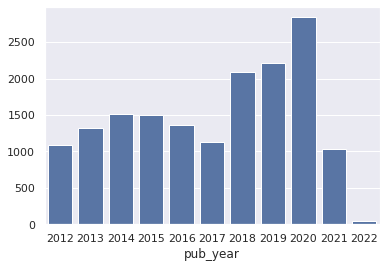

In [25]:
c = df.groupby('pub_year').sum()['num_citations']
sns.barplot(x=c.index, y=c.values, color='b')

### Average citations per publication (AC)

In [26]:
ac = tc / tp
ac

38.132387706855795

In [27]:
acp = (df.groupby('pub_year').sum()['num_citations'] / df.groupby('pub_year').count()['id'])

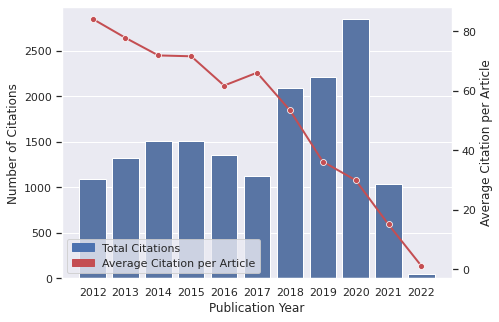

In [28]:
fig, ax1 = plt.subplots(figsize=(7,5))

sns.barplot(x=c.index, y=c.values, ax=ax1, color='b', label='d')
ax2 = ax1.twinx()
# ax1.grid(False)
ax2.grid(False)

sns.lineplot(x=ax1.get_xticks(), y=acp.values, ax=ax2, color='r', label='a', linewidth=2, marker='o')

bar = mpatches.Patch(color='b', label='Total Citations')
line = mpatches.Patch(color='r', label='Average Citation per Article')
plt.legend(handles=[bar, line], loc='lower left')

ax1.set_xlabel('Publication Year')
ax2.set_ylabel('Average Citation per Article')
ax1.set_ylabel('Number of Citations')
plt.savefig('citations.pdf')

### Top Articles

In [29]:
df.sort_values('num_citations', ascending=False).head(10)[['title', 'publisher', 'journal', 'num_citations']]

title  \
6     Prediction of in-hospital mortality in emergency department patients with se...   
316   An explainable deep-learning algorithm for the detection of acute intracrani...   
61    Multicentre validation of a sepsis prediction algorithm using only vital sig...   
171   Quantitative forecasting of PTSD from early trauma responses: A machine lear...   
8     Creating an automated trigger for sepsis clinical decision support at emerge...   
751   Machine-learning-based electronic triage more accurately differentiates pati...   
108              Predicting asthma-related emergency department visits using big data   
2     Emergency department triage prediction of clinical outcomes using machine le...   
1109  A comprehensive review of emergency department simulation applications for n...   
154   The development of a machine learning inpatient acute kidney injury predicti...   

                                            publisher  \
6                                Wiley Online Library   
316                           Nature Publishing Group   
61           British Medical Journal Publishing Group   
171                                          Elsevier   
8     Public Library of Science San Francisco, CA USA   
751                                          Elsevier   
108                                              IEEE   
2                                      BioMed Central   
1109                                         Elsevier   
154                                               LWW   

                                                journal  num_citations  
6                           Academic emergency medicine            352  
316                       Nature biomedical engineering            241  
61                                             BMJ open            221  
171                     Journal of psychiatric research            217  
8                                              PloS one            215  
751                        Annals of emergency medicine            202  
108   IEEE journal of biomedical and health informatics            195  
2                                         Critical care            188  
1109                Computers \& Industrial Engineering            187  
154                              Critical care medicine            182

### Top Authors

In [30]:
# Number of articles
a_tp = mdf.groupby('author_id').count()['article_id'].rename('TP')
# Number of cited articles
a_tcp = mdf[mdf['num_citations'] > 0].groupby('author_id').count()['article_id'].rename('TCP')
# Total citations
a_tc = mdf.groupby('author_id').sum()['num_citations'].rename('TC')
# Cites per publication (TC/TP)
a_tctp = (a_tc / a_tp).rename('TC/TP')
# Cites per cited publication (TC/TCP)
a_tctcp = (a_tc / a_tcp).rename('TC/TCP')
authors = pd.concat([adf.set_index('id')[['scholar_id', 'name', 'fullname', 'affiliation']], a_tp, a_tcp, a_tc, a_tctp, a_tctcp], axis=1).sort_values('TP', ascending=False).dropna(subset=['TP'])
top_authors = authors[authors['TP'] >= 5]
top_authors

scholar_id                  name          fullname  \
54   ceF698kAAAAJ              Liu, Nan      Nan LIU, PhD   
100  xp42UmcAAAAJ  Ong, Marcus Eng Hock           MEH ONG   
173  xpIPIQEAAAAJ     Ho, Andrew Fu Wah  Andrew Fu Wah Ho   
57   D_OcA1sAAAAJ        Koh, Zhi Xiong            ZX KOH   
824  DMd-2NEAAAAJ     Kwon, Joon-myoung  Joon-myoung Kwon   
6    AZcprXQAAAAJ      Taylor, R Andrew     Andrew Taylor   
30   sU6x0E0AAAAJ         Halpern, Yoni      Yoni Halpern   
19   _YyfF9EAAAAJ          Kadri, Farid       Farid Kadri   

                                                                         affiliation  \
54                                                           Duke-NUS Medical School   
100                                    Senior Consultant, Singapore General Hospital   
173                                                       Singapore General Hospital   
57                                                        Singapore General Hospital   
824  Department of Critical care and Emergency Medicine, Incheon Sejong Hospital,...   
6                                                                    Yale University   
30                                                                            Google   
19                                                                Sopra Steria Group   

       TP   TCP     TC       TC/TP      TC/TCP  
54   14.0  13.0  408.0   29.142857   31.384615  
100   9.0   8.0  222.0   24.666667   27.750000  
173   7.0   7.0   82.0   11.714286   11.714286  
57    7.0   7.0  306.0   43.714286   43.714286  
824   5.0   5.0  197.0   39.400000   39.400000  
6     5.0   5.0  653.0  130.600000  130.600000  
30    5.0   5.0  267.0   53.400000   53.400000  
19    5.0   5.0  101.0   20.200000   20.200000

### Top Publishers

In [31]:
p_tp = df.groupby('publisher').count()['id'].astype(int).rename('TP')
p_tcp = df[df['num_citations'] > 0].groupby('publisher').count()['id'].astype(int).rename('TCP')
p_tc = df.groupby('publisher').sum()['num_citations'].astype(int).rename('TC')
p_tctp = (round(p_tc / p_tp, 2)).rename('TC/TP')
p_tctcp = (round(p_tc / p_tcp, 2)).rename('TC/TCP')
pd.concat([p_tp, p_tcp, p_tc, p_tctp, p_tctcp], axis=1).sort_values('TC', ascending=False).head(10)

TP   TCP    TC  TC/TP  TC/TCP
publisher                                                                     
Elsevier                                         99  93.0  4308  43.52   46.32
Springer                                         37  36.0  1733  46.84   48.14
Wiley Online Library                             31  31.0  1654  53.35   53.35
Public Library of Science San Francisco, CA USA  11  11.0   694  63.09   63.09
BioMed Central                                   12  11.0   692  57.67   62.91
Nature Publishing Group                          16  15.0   602  37.62   40.13
IEEE                                             10   9.0   476  47.60   52.89
British Medical Journal Publishing Group          7   7.0   445  63.57   63.57
Radiological Society of North America             6   6.0   401  66.83   66.83
LWW                                               8   7.0   330  41.25   47.14

### Top Journals

In [32]:
df['journal'] = df['journal'].apply(lambda j: j.lower() if not pd.isna(j) else '')
j_p = df.groupby('journal')['publisher'].first()
j_tp = df.groupby('journal').count()['id'].astype(int).rename('TP')
j_tcp = df[df['num_citations'] > 0].groupby('journal').count()['id'].astype(int).rename('TCP')
j_tc = df.groupby('journal').sum()['num_citations'].astype(int).rename('TC')
j_tctp = (round(j_tc / j_tp, 2)).rename('TC/TP')
j_tctcp = (round(j_tc / j_tcp, 2)).rename('TC/TCP')
pd.concat([j_p, j_tp, j_tcp, j_tc, j_tctp, j_tctcp], axis=1).sort_values('TC', ascending=False).head(11)

publisher  \
journal                                                                                                                 
annals of emergency medicine                                                                                 Elsevier   
academic emergency medicine                                                                      Wiley Online Library   
plos one                                                              Public Library of Science San Francisco, CA USA   
                                                                                                      Hindawi Limited   
the american journal of emergency medicine                                                                   Elsevier   
critical care                                                                                          BioMed Central   
bmj open                                                                     British Medical Journal Publishing Group   
ieee journal of biomedical and health informatics                                                                IEEE   
internal and emergency medicine                                                                              Springer   
international journal of medical informatics                                                                 Elsevier   
scandinavian journal of trauma, resuscitation and emergency medicine                                         Springer   

                                                                      TP  \
journal                                                                    
annals of emergency medicine                                          17   
academic emergency medicine                                           13   
plos one                                                              11   
                                                                      39   
the american journal of emergency medicine                             8   
critical care                                                          3   
bmj open                                                               6   
ieee journal of biomedical and health informatics                      5   
internal and emergency medicine                                        5   
international journal of medical informatics                          13   
scandinavian journal of trauma, resuscitation and emergency medicine   5   

                                                                       TCP  \
journal                                                                      
annals of emergency medicine                                          17.0   
academic emergency medicine                                           13.0   
plos one                                                              11.0   
                                                                      27.0   
the american journal of emergency medicine                             8.0   
critical care                                                          3.0   
bmj open                                                               6.0   
ieee journal of biomedical and health informatics                      5.0   
internal and emergency medicine                                        4.0   
international journal of medical informatics                          13.0   
scandinavian journal of trauma, resuscitation and emergency medicine   5.0   

                                                                        TC  \
journal                                                                      
annals of emergency medicine                                          1185   
academic emergency medicine                                           1120   
plos one                                                               694   
                                                                       511   
the american journal of emergency medicine                    

### Top Affiliations

In [ ]:
def get_aff(aff):
  afl = aff.split('|')
  if len(afl) < 2:
    return aff
  if afl[0] == 'Unknown':
    return afl[-1]
  return afl[0]

mdf['affiliation']=mdf['affiliation'].fillna('Unknown')
mdf['fullname']=mdf['fullname'].fillna('Unknown')
dfa = mdf.groupby('article_id').agg({'fullname': '|'.join, 'affiliation': '|'.join}).merge(df, left_on='article_id', right_on='id')
dfa['single_affiliation'] = dfa['affiliation'].apply(get_aff)

# Manually fix affiliations
aff_re = pd.read_csv('affilitions_cleaned.csv')
aff_re = aff_re.set_index('single_affiliation.1')
dfa['single_affiliation'] = dfa.single_affiliation.apply(lambda x: aff_re.loc[x]['single_affiliation'])

af_tp = dfa.groupby('single_affiliation').count()['id'].astype(int).rename('TP')
af_tcp = dfa[dfa['num_citations'] > 0].groupby('single_affiliation').count()['id'].astype(int).rename('TCP')
af_tc = dfa.groupby('single_affiliation').sum()['num_citations'].astype(int).rename('TC')
af_tctp = (round(af_tc / af_tp, 2)).rename('TC/TP')
af_tctcp = (round(af_tc / af_tcp, 2)).rename('TC/TCP')
pd.concat([af_tp, af_tcp, af_tc, af_tctp, af_tctcp], axis=1).sort_values(['TP', 'TC'], ascending=False).head(11)


## Text Analysis

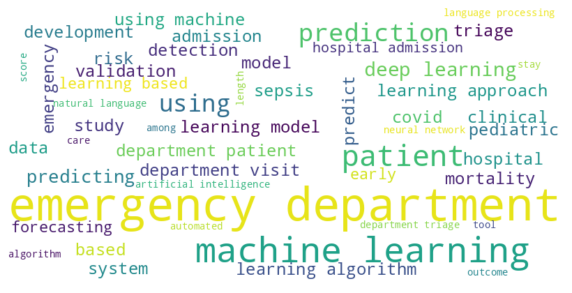

<Figure size 432x288 with 0 Axes>

In [36]:
stopwords = set(STOPWORDS)
# stopwords.update(['emergency', 'department', 'machine', 'learning', 'deep', 'emergency department', 'machine learning', 'deep learning'])

title_text = " ".join(title.lower() for title in df.title)
abstract_text = " ".join(title.lower() for title in df.title)
text = title_text + " " + abstract_text

wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=50, background_color="white", scale=2).generate(title_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('wordcloud.pdf')
# wordcloud.words_

{'patient': 1.0, 'risk': 0.42105263157894735, 'using': 0.2631578947368421, 'time': 0.2631578947368421, 'system': 0.2631578947368421, 'prediction': 0.15789473684210525, 'learning': 0.15789473684210525, 'heart': 0.15789473684210525, 'early': 0.15789473684210525, 'automated': 0.15789473684210525, 'classification': 0.15789473684210525, 'reports': 0.15789473684210525, 'triage': 0.15789473684210525, 'care': 0.15789473684210525, 'model': 0.15789473684210525, 'comparison': 0.15789473684210525, 'factors': 0.15789473684210525, 'presenting': 0.10526315789473684, 'machine': 0.10526315789473684, 'score': 0.10526315789473684, 'predicting': 0.10526315789473684, 'complaints': 0.10526315789473684, 'clinical': 0.10526315789473684, 'integrated': 0.10526315789473684, 'networks': 0.10526315789473684, 'stratification': 0.10526315789473684, 'pediatric': 0.10526315789473684, 'tool': 0.10526315789473684, 'within': 0.10526315789473684, 'hours': 0.10526315789473684, 'hospital': 0.10526315789473684, 'identify': 0

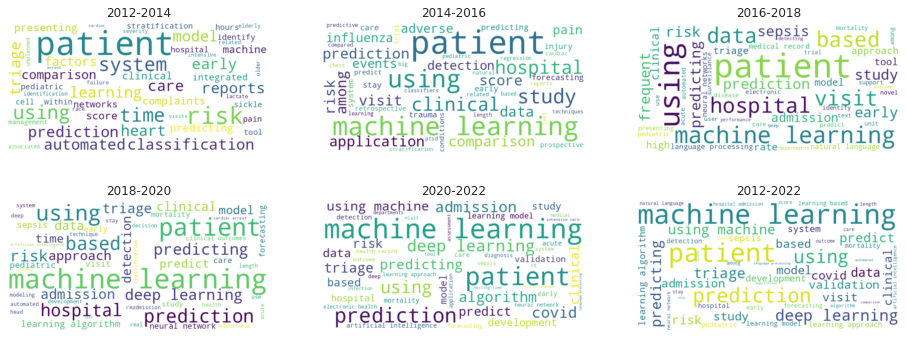

In [37]:
stopwords2 = set(STOPWORDS)
stopwords2.update(['emergency', 'department', 'emergency department'])

fig, ax = plt.subplots(2, 3)
fig.set_size_inches((16,6))
wcs = []
for i, year in enumerate(range(2012, 2021, 2)):
  text = " ".join(title.lower() for title in df[((df['pub_year'] >= year) & (df['pub_year'] < year+2))].title)
  wordcloud = WordCloud(stopwords=stopwords2,max_font_size=50, max_words=50, background_color="white", scale=2).generate(text)
  ax[i//3][i%3].imshow(wordcloud, interpolation='bilinear')
  ax[i//3][i%3].axis("off")
  ax[i//3][i%3].set_title(str(year) + '-' + str(year+2))
  print(wordcloud.words_)

wordcloud = WordCloud(stopwords=stopwords2,max_font_size=50, max_words=50, background_color="white", scale=2).generate(title_text)
ax[1][2].imshow(wordcloud, interpolation='bilinear')
ax[1][2].axis("off")
ax[1][2].set_title('2012-2022')


fig.savefig('wordclouds_over_time.pdf')

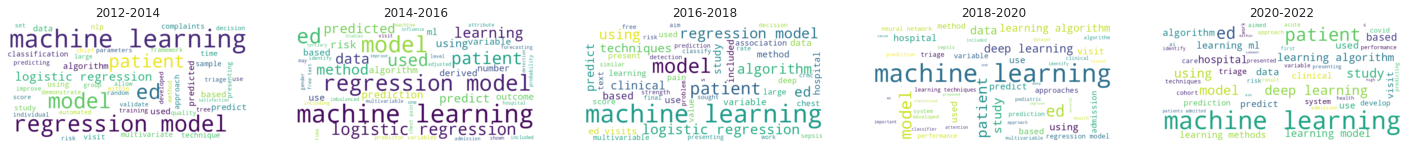

In [39]:
stopwords2 = set(STOPWORDS)
stopwords2.update(['emergency', 'department', 'emergency department'])

fig, ax = plt.subplots(1, 5)
fig.set_size_inches((25,8))
wcs = []
for i, year in enumerate(range(2012, 2021, 2)):
  text = " ".join(abstract.lower() for abstract in df[((df['pub_year'] >= year) & (df['pub_year'] < year+2))].abstract)
  wordcloud = WordCloud(stopwords=stopwords2,max_font_size=50, max_words=50, background_color="white", scale=2).generate(text)
  ax[i].imshow(wordcloud, interpolation='bilinear')
  ax[i].axis("off")
  ax[i].set_title(str(year) + '-' + str(year+2))

### LDA


In [ ]:
import gensim
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['emergency', 'department', 'machine', 'learning', 'deep', 'emergency department', 'machine learning', 'deep learning'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df.title_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:3])

In [ ]:
from pprint import pprint
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()


LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

### BERTopic

In [41]:
from plotly.offline import init_notebook_mode
init_notebook_mode() 

In [60]:
from bertopic import BERTopic
from umap import UMAP

from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['emergency', 'department', 'machine', 'learning', 'deep', 'emergency department', 'machine learning', 'deep learning'])


titles = df.title.apply(lambda t: ' '.join([word for word in simple_preprocess(str(t)) if word not in stop_words])).values
years = df.pub_year.values


umap_model = UMAP(random_state=1)
seed_topic_list = [['triage', 'predict', 'patient', 'hospital', 'visit'],
                   ['language', 'natural language processing', 'suicide', 'records', 'text'],
                   ['covid', 'chest', 'diagnosis', 'clinical', 'predict'],
                   ['sepsis', 'early', 'septic', 'mortality', 'shock'],
                   ['cardiac', 'chest pain', 'heart', 'acute', 'chest'],
                   ['trauma', 'head', 'computed tomography', 'brain', 'image']]
topic_model = BERTopic(verbose=True, embedding_model="all-mpnet-base-v2", n_gram_range=(1,3), nr_topics=7, umap_model=umap_model, seed_topic_list=seed_topic_list)
topics, _ = topic_model.fit_transform(titles)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

2023-03-23 18:13:31,807 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-23 18:13:34,330 - BERTopic - Reduced dimensionality
2023-03-23 18:13:34,351 - BERTopic - Clustered reduced embeddings
2023-03-23 18:13:35,696 - BERTopic - Reduced number of topics from 7 to 7


In [61]:
topic_model.get_topic_info()

Topic  Count  \
0     -1     35   
1      0     41   
2      1    191   
3      2     32   
4      3     44   
5      4     33   
6      5     47   

                                                                 Name  
0                             -1_risk_patients_influenza_intelligence  
1  0_language_natural language processing_language processing_natural  
2                                    1_triage_using_hospital_patients  
3                                     2_trauma_head_ct_classification  
4                                     3_cardiac_pain_acute_chest pain  
5                                         4_sepsis_septic_early_shock  
6                                    5_covid_patients_diagnosis_chest

In [62]:
topic_model.set_topic_labels(['_', 'Natural Language Processing', 'Triage', 'Head Injury' , 'Cardiac', 'Sepsis', 'Covid-19'])

In [63]:
fig = topic_model.visualize_barchart(top_n_topics=9, custom_labels=True, n_words=10, height=500)
fig.show(renderer="colab")

In [64]:
fig = topic_model.visualize_hierarchy(top_n_topics=50, width=500, custom_labels=True)
fig.show(renderer="colab")

In [65]:
fig = topic_model.visualize_heatmap(custom_labels=True)
fig.show(renderer="colab")

In [66]:
fig = topic_model.visualize_topics()
fig.show(renderer='colab')

In [67]:
topics_over_time = topic_model.topics_over_time(titles, df.pub_year.values)
fig = topic_model.visualize_topics_over_time(topics_over_time, custom_labels=True, width=800)
fig.update_layout(
    legend=dict(
      yanchor="top",
      y=0.99,
      xanchor="left",
      x=0.01,
      title=None,
      bgcolor="rgba(255,255,255,0.6)",
      bordercolor="#CACAD2",
      borderwidth=1
    ),
    # title=dict(
    #     text='Publication titles over time',
    #     xanchor='left',
    #     font=dict(
    #         family='Arial',
    #         size=18,
    #         color='black'
    #     ),
    #     pad=dict(r=0,t=0,b=0,l=0)
    # ),
    font=dict(size=14),
    title=None,
    xaxis=dict(title='Publication Year', showgrid=False, showline=False),
    yaxis=dict(gridcolor='white', showline=False),
    plot_bgcolor='#EAEAF2'
)

plotly.io.write_image(fig, 'topics_over_time.pdf', format='pdf')
fig.show(renderer='colab')

11it [00:00, 15.67it/s]


# Citation Analysis

In [68]:
top_authors

scholar_id                  name          fullname  \
54   ceF698kAAAAJ              Liu, Nan      Nan LIU, PhD   
100  xp42UmcAAAAJ  Ong, Marcus Eng Hock           MEH ONG   
173  xpIPIQEAAAAJ     Ho, Andrew Fu Wah  Andrew Fu Wah Ho   
57   D_OcA1sAAAAJ        Koh, Zhi Xiong            ZX KOH   
824  DMd-2NEAAAAJ     Kwon, Joon-myoung  Joon-myoung Kwon   
6    AZcprXQAAAAJ      Taylor, R Andrew     Andrew Taylor   
30   sU6x0E0AAAAJ         Halpern, Yoni      Yoni Halpern   
19   _YyfF9EAAAAJ          Kadri, Farid       Farid Kadri   

                                                                         affiliation  \
54                                                           Duke-NUS Medical School   
100                                    Senior Consultant, Singapore General Hospital   
173                                                       Singapore General Hospital   
57                                                        Singapore General Hospital   
824  Department of Critical care and Emergency Medicine, Incheon Sejong Hospital,...   
6                                                                    Yale University   
30                                                                            Google   
19                                                                Sopra Steria Group   

       TP   TCP     TC       TC/TP      TC/TCP  
54   14.0  13.0  408.0   29.142857   31.384615  
100   9.0   8.0  222.0   24.666667   27.750000  
173   7.0   7.0   82.0   11.714286   11.714286  
57    7.0   7.0  306.0   43.714286   43.714286  
824   5.0   5.0  197.0   39.400000   39.400000  
6     5.0   5.0  653.0  130.600000  130.600000  
30    5.0   5.0  267.0   53.400000   53.400000  
19    5.0   5.0  101.0   20.200000   20.200000

[]

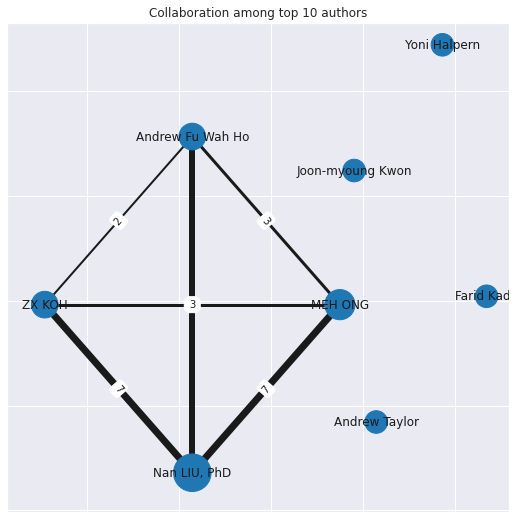

In [69]:
tac_df = cdf[cdf.author_id.isin(top_authors.index)].groupby('article_id').agg(authors=('author_id', lambda x: ','.join(map(str, x))), authors_count=('author_id', 'count'))

tac_graph = nx.Graph()

tac_graph.add_nodes_from(list(top_authors.index))

for row in tac_df[tac_df['authors_count'] > 1]['authors']:
  lst = row.split(',')
  for idx, a in enumerate(lst):
    for b in lst[idx + 1:]:
      w = 1
      if tac_graph.get_edge_data(int(a), int(b)):
        w = tac_graph.get_edge_data(int(a), int(b))['weight'] + 1
      tac_graph.add_edge(int(a), int(b), weight=w)


fig, ax = plt.subplots(figsize=(9,9))

pos = nx.nx_agraph.graphviz_layout(tac_graph, prog='circo')

node_labels = top_authors['fullname'].to_dict()
nx.draw_networkx_labels(tac_graph, pos, labels=node_labels, font_size=12, ax=ax)
nx.draw_networkx_nodes(tac_graph, pos, node_size=(10 + 100 * top_authors['TP']).to_list(), ax=ax)

edges = tac_graph.edges()
weights = [tac_graph[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(tac_graph, pos, width=weights, ax=ax)
edge_labels = nx.get_edge_attributes(tac_graph, 'weight')
nx.draw_networkx_edge_labels(tac_graph, pos, edge_labels, ax=ax)


plt.title('Collaboration among top 10 authors')
plt.plot()

In [70]:
authors['graph_name'] = (authors[authors.index.isin(top_authors.index)]['fullname'])
authors['graph_name'] = authors['graph_name'].fillna('')


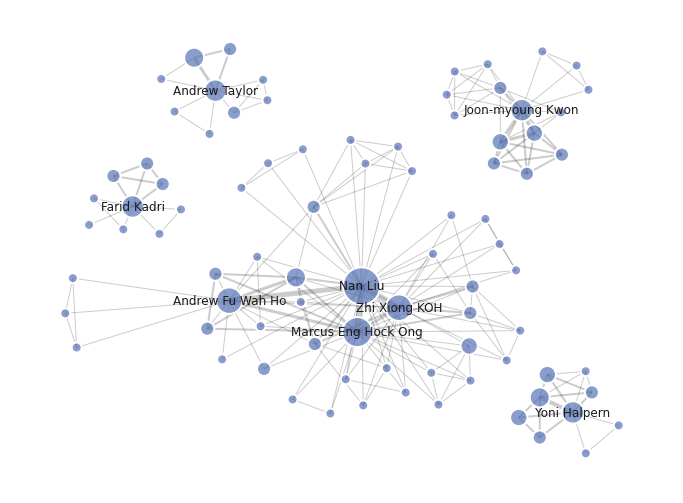

In [74]:
taa = mdf[mdf.author_id.isin(top_authors.index)].article_id.unique()
tac_df = cdf[cdf.article_id.isin(taa)].groupby('article_id').agg(authors=('author_id', lambda x: ','.join(map(str, x))), authors_count=('author_id', 'count'))

tac_graph = nx.Graph()

nodes = mdf[mdf.article_id.isin(taa)]['author_id'].sort_values().unique()
tac_graph.add_nodes_from(nodes)

for row in tac_df[tac_df['authors_count'] > 1]['authors']:
  lst = row.split(',')
  for idx, a in enumerate(lst):
    for b in lst[idx + 1:]:
      w = 1
      if tac_graph.get_edge_data(int(a), int(b)):
        w = tac_graph.get_edge_data(int(a), int(b))['weight'] + 1
      tac_graph.add_edge(int(a), int(b), weight=w)


fig, ax = plt.subplots(figsize=(12,9))

# neato, dot, twopi, circo, fdp, sfdp
pos = nx.nx_agraph.graphviz_layout(tac_graph, prog='fdp')

node_labels = authors[authors.index.isin(nodes)]['graph_name'].to_dict()
node_labels.update({
    54: 'Nan Liu',
    100: 'Marcus Eng Hock Ong',
    173: 'Andrew Fu Wah Ho',
    57: 'Zhi Xiong KOH',
    824: 'Joon-myoung Kwon',
    6: 'Andrew Taylor',
    30: 'Yoni Halpern',
    19: 'Farid Kadri'
})
node_sizes = 100*authors[authors.index.isin(nodes)]['TP'].sort_index().to_numpy()
nx.draw_networkx_labels(tac_graph, pos, labels=node_labels, font_size=12, ax=ax)
nx.draw_networkx_nodes(tac_graph, pos, node_size=node_sizes, ax=ax, node_color=(88/255,117/255,184/255,0.7),edgecolors='#FFF',linewidths=2)

edges = tac_graph.edges()
weights = [tac_graph[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(tac_graph, pos, width=weights, ax=ax, edge_color=(0,0,0,0.2))
edge_labels = nx.get_edge_attributes(tac_graph, 'weight')
# nx.draw_networkx_edge_labels(tac_graph, pos, edge_labels, ax=ax)


# plt.title('Collaboration among most active authors and their immediate coauthors')
plt.grid(False)
ax.set_facecolor('white')
plt.plot()
plt.savefig('colab_top.pdf')

In [79]:
nodes = authors.dropna(subset=['TP']).reset_index().rename(columns={'index': 'author_id'})
nodes

author_id    scholar_id                  name          fullname  \
0            54  ceF698kAAAAJ              Liu, Nan      Nan LIU, PhD   
1           100  xp42UmcAAAAJ  Ong, Marcus Eng Hock           MEH ONG   
2           173  xpIPIQEAAAAJ     Ho, Andrew Fu Wah  Andrew Fu Wah Ho   
3            57  D_OcA1sAAAAJ        Koh, Zhi Xiong            ZX KOH   
4           824  DMd-2NEAAAAJ     Kwon, Joon-myoung  Joon-myoung Kwon   
...         ...           ...                   ...               ...   
1337        556           NaN       Mostafavi, Amir               NaN   
1338        553  e5nvg68AAAAJ       Lu, Tsung-Chien    Tsung-Chien Lu   
1339        552           NaN        Wang, Shen-Tsu               NaN   
1340        551  cplFxEkAAAAJ         Park, Jungkyu      Jungkyu Park   
1341       5610           NaN        Haber, Jordana               NaN   

                                                                          affiliation  \
0                                                             Duke-NUS Medical School   
1                                       Senior Consultant, Singapore General Hospital   
2                                                          Singapore General Hospital   
3                                                          Singapore General Hospital   
4     Department of Critical care and Emergency Medicine, Incheon Sejong Hospital,...   
...                                                                               ...   
1337                                                                              NaN   
1338                                              National Taiwan University Hospital   
1339                                                                              NaN   
1340                                                              New York University   
1341                                                                              NaN   

        TP   TCP     TC      TC/TP     TC/TCP        graph_name  
0     14.0  13.0  408.0  29.142857  31.384615      Nan LIU, PhD  
1      9.0   8.0  222.0  24.666667  27.750000           MEH ONG  
2      7.0   7.0   82.0  11.714286  11.714286  Andrew Fu Wah Ho  
3      7.0   7.0  306.0  43.714286  43.714286            ZX KOH  
4      5.0   5.0  197.0  39.400000  39.400000  Joon-myoung Kwon  
...    ...   ...    ...        ...        ...               ...  
1337   1.0   NaN    0.0   0.000000        NaN                    
1338   1.0   NaN    0.0   0.000000        NaN                    
1339   1.0   1.0   24.0  24.000000  24.000000                    
1340   1.0   1.0   59.0  59.000000  59.000000                    
1341   1.0   1.0   24.0  24.000000  24.000000                    

[1342 rows x 11 columns]

In [80]:
links_df = cdf[cdf.article_id.isin(df.id.unique())]
# links_df.groupby('article_id').count()
links = {}
for name, group in links_df.groupby('article_id'):
  g_authors = group['author_id'].to_list()
  for i in range(len(g_authors)):
    for j in range(i):
      p = (g_authors[i], g_authors[j])
      links[p] = links.get(p, 0) + 1

links = [(link[0], link[1], weight) for link, weight in links.items()]
links_df = pd.DataFrame(columns=['a', 'b', 'w'], data=links)
links_df

a     b  w
0        2     1  1
1        3     1  1
2        3     2  1
3        4     1  1
4        4     2  1
...    ...   ... ..
2164  5609  5607  1
2165  5609  5608  1
2166  5610  5607  1
2167  5610  5608  1
2168  5610  5609  1

[2169 rows x 3 columns]

In [81]:
N = len(nodes)
d=nodes.reset_index().set_index('author_id')['index']
adj = np.zeros((N,N))
for i, row in links_df.iterrows():
  a = d[row['a']]
  b = d[row['b']]
  w = row['w']
  adj[a, b] = w
  adj[b, a] = w

pd.DataFrame(adj).to_csv('adj.csv', index=False, header=None)

In [82]:
d = nodes['author_id']
d=nodes.reset_index().set_index('author_id')['index']

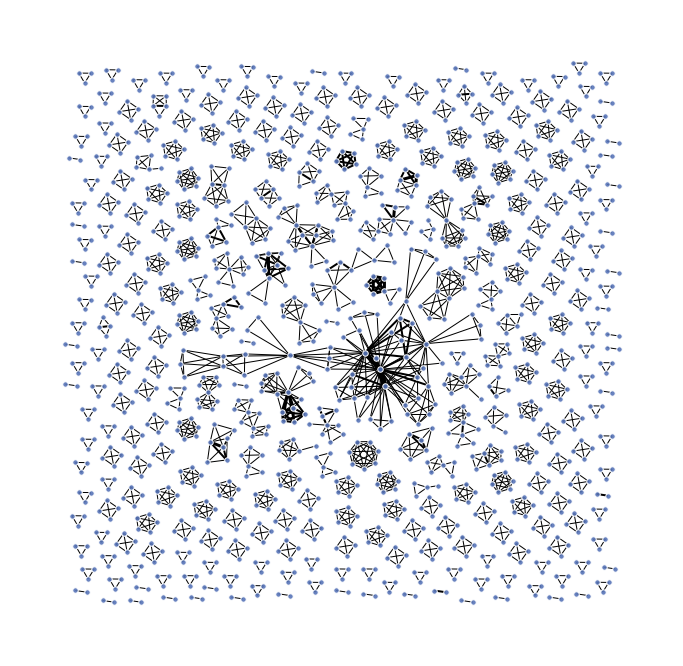

In [83]:
cg = nx.Graph()
for i, row in links_df.iterrows():
  cg.add_edge(int(row['a']), int(row['b']), weight=row['w'])

# tac_graph.remove_nodes_from([node for node,degree in dict(tac_graph.degree()).items() if degree < 2])

fig, ax = plt.subplots(figsize=(12,12))

# neato, dot, twopi, circo, fdp, sfdp
pos = nx.nx_agraph.graphviz_layout(cg, prog='fdp')

nx.draw_networkx_nodes(cg, pos, node_size=30, ax=ax, node_color=(88/255,117/255,184/255,0.9),edgecolors='#FFF',linewidths=1)

edges = cg.edges()
weights = [cg[u][v]['weight'] for u,v in edges]
nx.draw_networkx_edges(cg, pos, width=weights, ax=ax, edge_color=(0,0,0,1))


# plt.title('Collaboration among top 10 authors')
plt.grid(False)
ax.set_facecolor('white')
plt.plot()
plt.savefig('collab_all.pdf')